In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [4]:
sess = tf.InteractiveSession()

In [6]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=500, n_components_in_mixture=4, n_features=2, n_sources=2, data_var_rate=1.)

In [7]:
generated = sess.run(ifa.tape)
fica = FastICA(n_components=2).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())
#initial = dict(generated)
#initial.pop('data')
#sess.run(ifa.assigner(**initial))
sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_std'], 10*np.ones(ifa.unconstrained_variables['mixture_component_std'].shape)))
#sess.run(tf.assign(ifa.unconstrained_variables['data_std'], 1e-3*np.ones(ifa.unconstrained_variables['data_std'].shape)))
start = sess.run(ifa.variables)
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
opt.minimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -4441.358398
  Number of iterations: 77
  Number of functions evaluations: 152


In [8]:
predicted = sess.run(ifa.variables)
print(predicted)

{'mixture_component_var': array([[1.2224590e-03, 2.5388354e-04, 7.7363838e-05, 9.5905047e-03],
       [3.3141233e-03, 1.6824153e-03, 1.6875433e-07, 2.9205850e-05]],
      dtype=float32), 'mixture_weights': array([[8.1619203e-01, 8.9537688e-02, 2.5326019e-02, 6.8944305e-02],
       [3.2462634e-05, 1.7619892e-05, 9.9941051e-01, 5.3946109e-04]],
      dtype=float32), 'sources': array([[ 4.63959202e-02,  1.06261228e-03],
       [-4.47521247e-02, -2.69952987e-04],
       [ 4.07783575e-02,  2.51216292e-02],
       [ 4.71155234e-02,  1.18654251e-01],
       [-6.98871398e-03,  3.42990123e-02],
       [ 1.82233192e-03, -5.73654845e-03],
       [ 5.98547468e-03, -8.75251368e-04],
       [ 6.94598258e-02,  5.79203069e-02],
       [ 6.68407679e-02, -9.11750123e-02],
       [-8.28248076e-03,  6.25398308e-02],
       [ 4.19317298e-02,  7.45759532e-02],
       [-4.95316088e-03,  3.84718403e-02],
       [-3.19963992e-02, -3.55632938e-02],
       [-5.81905283e-02, -2.36327338e-04],
       [ 2.88739298e

In [9]:
fgen = generated['factor_loadings']
fpred = predicted['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

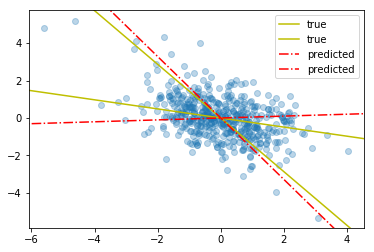

In [10]:
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



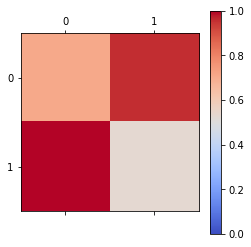

In [11]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],predicted['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [12]:
ifa.variables

{'mixture_component_var': <tf.Tensor 'ifa2/softplus_2/forward/Softplus:0' shape=(2, 4) dtype=float32>,
 'mixture_weights': <tf.Tensor 'ifa2/softmax_centered/forward/Softmax:0' shape=(2, 4) dtype=float32>,
 'sources': <tf.Tensor 'ifa2/sources/read:0' shape=(500, 2) dtype=float32>,
 'factor_loadings': <tf.Tensor 'ifa2/factor_loadings/read:0' shape=(2, 2) dtype=float32>,
 'data_var': <tf.Tensor 'ifa2/softplus_3/forward/Softplus:0' shape=(1, 2) dtype=float32>}

In [15]:
generated['mixture_component_var'].shape

(2, 4)

In [14]:
tfd.Normal()

TypeError: __init__() missing 2 required positional arguments: 'loc' and 'scale'

In [17]:
def plot_source_distributions(mixture_component_std):
    n_sources,n_components_in_mixture = mixture_component_std.shape
    batch_event_space = np.stack((n_sources*n_components_in_mixture)*[np.linspace(-6,6,1000).astype(np.float32)],axis=1).reshape(-1,n_sources,n_components_in_mixture)
    densities = sources.distribution.distribution.components_distribution.prob(batch_event_space)
    for i in range(n_sources):
        plt.show()
        for j in range(n_components_in_mixture):
            plt.plot(batch_event_space[:,i,j],densities[:,i,j])
    plt.show()

In [19]:
generated

OrderedDict([('mixture_component_std',
              array([[0.640777  , 0.27250516, 1.8845321 , 0.26461598],
                     [0.22620392, 1.8344245 , 0.86785775, 1.6288322 ]], dtype=float32)),
             ('mixture_weights',
              array([[0.08403518, 0.68335176, 0.15398364, 0.07862946],
                     [0.12367655, 0.03872857, 0.09778094, 0.7398139 ]], dtype=float32)),
             ('sources', array([[ 9.73942056e-02, -1.69365513e+00],
                     [ 2.49939859e-01,  1.74021106e-02],
                     [-5.33903122e-01,  2.25465560e+00],
                     [-1.72935277e-01, -1.80959034e+00],
                     [ 8.23087767e-02,  1.45218337e+00],
                     [-1.52928814e-01,  4.59154576e-01],
                     [ 2.99361706e+00,  1.18856800e+00],
                     [-2.18049213e-02, -4.57912892e-01],
                     [-2.11829752e-01,  2.60694414e-01],
                     [-1.13511789e+00, -1.16857804e-01],
                     [-6.39

In [18]:
testinput = dict(ifa.variables)
testinput.pop('sources')

def centeredIndependentFactorAnalysisTest(n_observations, mc_samples, factor_loadings, mixture_weights, mixture_component_std, data_std):
    sources = ed.Independent(
        tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mixture_weights),
            components_distribution=tfd.Normal(loc=tf.zeros_like(mixture_component_std), scale=mixture_component_std, name='mixture_component')),
        reinterpreted_batch_ndims=1,sample_shape=(mc_samples, n_observations),name='sources')
    data_mean = tf.einsum('bik,kj->ijb', sources, factor_loadings, name='data_mean')
    data = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=tf.ones(mc_samples)/mc_samples),
                components_distribution=tfd.Normal(loc=data_mean, scale=data_std[:,:,None], name='data'), name='mc_approx')
    return data

plot_source_distributions(generated['sources'])

plt.scatter(*generated['data'].T)
plt.scatter(*sess.run(centeredIndependentFactorAnalysisTest(1000, 1, **testinput).sample()).T, alpha=.2)

AttributeError: 'numpy.ndarray' object has no attribute 'distribution'